### Untersuchung von XAI Methoden

Hier wird untersucht was Ergebnisse der XAI Methoden mit dem Alexnet sind. Für XAI gibt es eine gute Library namens Captum. Captum bietet eine vielzahl von Methoden an, hier eine Übersicht:

![alt text](/home/riccardnef/PycharmProjects/new/bachelor_thesis_2022/Notebooks/XAI/An-overview-of-all-the-attribution-algorithms-in-Captum-The-algorithms-grouped-on-the.png "Title")


Wir sehen, dass es eine Unterscheidung zwischen dem ganzen Model und den einzelnen Layern gibt. Diese Unterscheidung ist wichtig, da die Methoden nicht nur die Werte des einzelnen Layers, sondern auch die Werte der ganzen Model zurückgeben.

## Model laden


In [1]:
import torch

In [2]:
from monai.networks.nets import DenseNet121
import torch

# load state dict of model
MODEL_NAME = 'DenseNet121_LR0.0019676087078530735_CRFocal Loss_TRAugment_Normalize_OPAdamW_BS12_EP40__ID_02927019-cdb7-4c2e-82c0-4523867cac74.pth'
MODEL_PATH = 'model/'

model = DenseNet121(spatial_dims=2, in_channels=1, out_channels=2, pretrained=False).to("cpu")
model.load_state_dict(torch.load(MODEL_PATH + MODEL_NAME, map_location=torch.device('cpu')))
model.eval()
# transformer used during evaluation
from monai.transforms import (
    NormalizeIntensity,
    EnsureType,
)
from torchvision.transforms import transforms


def _monai_transformer_test():
    return transforms.Compose(
        [
            NormalizeIntensity(),
            EnsureType(),
            transforms.Grayscale(),
            transforms.Resize((512, 512))
        ]
    )

In [2]:
transform2 = transforms.Compose(
        [
            transforms.PILToTensor(),
            NormalizeIntensity(),
            EnsureType(),
            transforms.Grayscale(),
            transforms.Resize((512, 512))])

In [3]:
import torch
import torch.nn.functional as F

from PIL import Image

import os
import json
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

import torchvision
from torchvision import models
from torchvision import transforms

from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Saliency
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

torch.manual_seed(0)
np.random.seed(0)


# load the pretrained model
transform = transforms.Compose([
            #transforms.ToPILImage(),
            transforms.Grayscale(num_output_channels=1),
            transforms.Resize((512, 512)),
            transforms.ToTensor()
            ]
)


transform_normalize = transforms.Normalize(
     mean=0.5,
     std=0.5
 )

## Load the binary_annotation file

In [4]:
# load the image from filtered Dataset
import pandas as pd
df = pd.read_csv("data/binary_annotations.csv")

In [5]:
#tow random images fot the class target
def get_random_image(target_class):
    random_image = df[df['target'] == target_class].sample(1)
    image_path = random_image['filenames'].values[0]
    image_path = "data/flattened_flipped_cropped/" + image_path
    return image_path

In [6]:
def load_image(path):
    with torch.no_grad():
        img = Image.open(path)

        transformed_img = transform2(img)

        input = transform_normalize(transformed_img)
        input = input.unsqueeze(0)
        print(input.shape)

        output = model(input)
        #output = F.softmax(output, dim=1)
        print(output)
        prediction_score, pred_label_idx = torch.max(output, 1)

        pred_label_idx.squeeze_()
        print("item: ",path, "\n for Label ", )
        print(prediction_score)
        print('Predicted:', pred_label_idx.item(), )#'(', prediction_score.squeeze().item(), ')')

        return input, output, pred_label_idx,transformed_img

In [7]:
path_0 = get_random_image(0)
input, output, pred_label_idx,transformed_img = load_image(path_0)

torch.Size([1, 1, 512, 512])
tensor([[-0.1839,  0.0925]])
item:  data/flattened_flipped_cropped/DezGes61_dp.jpg 
 for Label 
tensor([0.0925])
Predicted: 1


In [92]:
Image.open(path_0)

'1.12.0+cu102'

In [27]:
path_1 = get_random_image(1)
input1, output1, pred_label_idx1,transformed_img1 = load_image(path_1)

item:  data/flattened_flipped_cropped/SeptFx19_dp.jpg 
 for Label 
Predicted: 1


## Methoden vergleich
### Integrierte Gradienten
Integrierte Gradienten stellen das Integral der Gradienten in Bezug auf die Eingaben entlang des Pfades von einer gegebenen Basislinie zur Eingabe dar. Das Integral kann mit Hilfe der Riemannschen Summe oder der Gauß-Legendre-Quadraturregel angenähert werden. Formal kann es wie folgt beschrieben werden:

IG_eq1 Integrierte Gradienten entlang der i-ten Dimension der Eingabe X. Alpha ist der Skalierungskoeffizient. Die Gleichungen sind aus dem Originalbeitrag übernommen.

Die Eckpfeiler dieses Ansatzes sind zwei grundlegende Axiome, nämlich Empfindlichkeit und Implementierungsinvarianz. Weitere Informationen zu diesen Axiomen finden Sie in der Originalarbeit.



Die Visualisierungen können folgende Formen haben:
1. `heat_map` - Display heat map of chosen attributions
2. `blended_heat_map` - Overlay heat map over greyscale version of original image. Parameter alpha_overlay corresponds to alpha of heat map.
3. `original_image` - Only display original image.
4. `masked_image` - Mask image (pixel-wise multiply) by normalized attribution values.
5. `alpha_scaling` - Sets alpha channel of each pixel
                       to be equal to normalized attribution value.


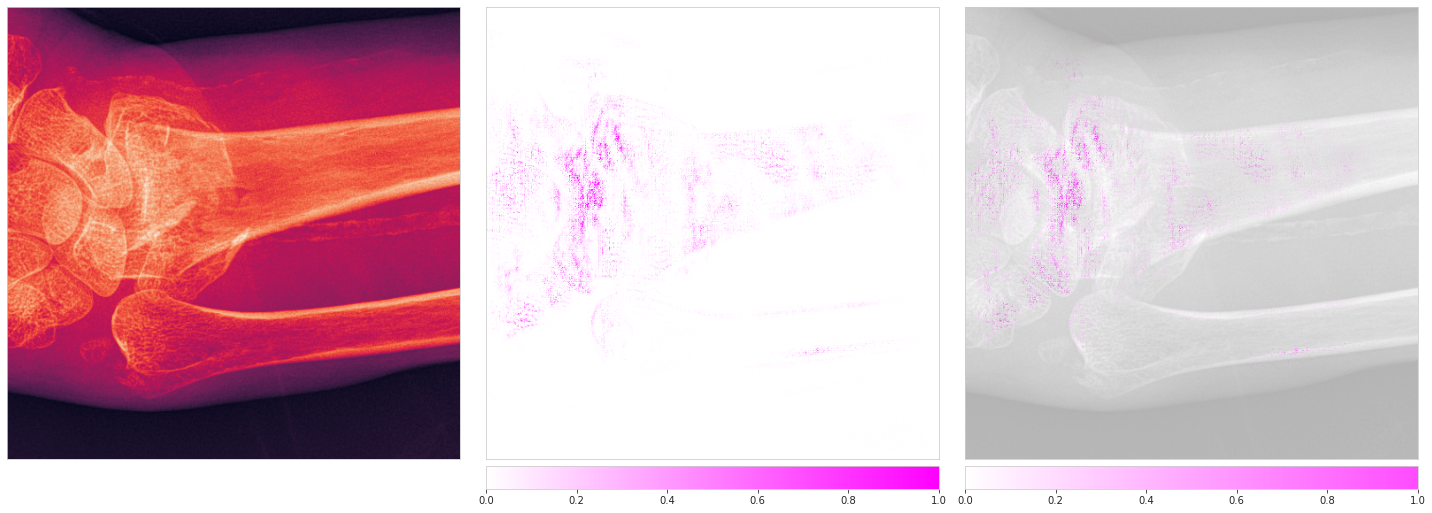

In [16]:
# Create IntegratedGradients object and get attributes
integrated_gradients = IntegratedGradients(model)
attributions_ig = integrated_gradients.attribute(input1, target=pred_label_idx1, n_steps=5)

# create custom colormap for visualizing the result
default_cmap = LinearSegmentedColormap.from_list('custom blue',
                                                 [(0, '#ffffff'),
                                                  (1, '#FF00FF')], N=256)


# visualize the results using the visualize_image_attr helper method
_ = viz.visualize_image_attr_multiple(
                             np.transpose(attributions_ig.cpu().detach().numpy()),
                             np.transpose(transformed_img1.cpu().detach().numpy()),
                             methods=["original_image", "heat_map","blended_heat_map"],
                             signs=['all', 'positive','positive'],
                             cmap=default_cmap,
                             show_colorbar=True,
                             fig_size=(20,20),
                             alpha_overlay=0.7)

## Noise Tunnel

Der Noise Tunnel fügt Gaußsches Rauschen zu jeder Eingabe im Batch nt_samples mal hinzu und wendet den gegebenen Attributionsalgorithmus auf jedes der Samples an. Die Zuordnungen der Samples werden basierend auf dem gegebenen Rauschtunneltyp (nt_type) kombiniert: Wenn nt_type smoothgrad ist, wird der Mittelwert der abgetasteten Zuordnungen zurückgegeben. Dies nähert sich der Glättung der gegebenen Zuordnungsmethode mit einem Gaussian Kernel an. Wenn nt_type gleich smoothgrad_sq ist, wird der Mittelwert der quadrierten Stichprobenzuordnungen zurückgegeben. Wenn nt_type vargrad ist, wird die Varianz der Stichprobenzuordnungen zurückgegeben.

In [ ]:
noise_tunnel = NoiseTunnel(integrated_gradients)

attributions_ig_nt = noise_tunnel.attribute(input, nt_type='smoothgrad_sq', target=pred_label_idx)

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             methods=["original_image", "heat_map","blended_heat_map"],
                             signs=['all', 'positive','positive'],
                             cmap=default_cmap,
                             show_colorbar=True,
                             fig_size=(20,20),
                             alpha_overlay=0.7)

### Gradient SHAP

Gradient SHAP ist eine Gradientenmethode zur Berechnung von SHAP-Werten, die auf den in der kooperativen Spieltheorie vorgeschlagenen Shapley-Werten beruhen. Gradient SHAP fügt jeder Eingabeprobe mehrfach Gaußsches Rauschen hinzu, wählt einen zufälligen Punkt entlang des Pfades zwischen Basislinie und Eingabe und berechnet den Gradienten der Ausgaben in Bezug auf diese ausgewählten Zufallspunkte. Die endgültigen SHAP-Werte stellen den Erwartungswert der Gradienten * (Eingänge - Basislinien) dar.

Die berechneten Attributionen approximieren die SHAP-Werte unter der Annahme, dass die Input-Merkmale unabhängig sind und dass das Erklärungsmodell zwischen den Inputs und den gegebenen Basislinien linear ist.


In [ ]:
gradient_shap = GradientShap(model)

# Defining baseline distribution of images
rand_img_dist = torch.cat([input * 0, input * 255])

attributions_gs = gradient_shap.attribute(input,
                                          n_samples=50,
                                          stdevs=0.0001,
                                          baselines=rand_img_dist,
                                          target=pred_label_idx)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_gs.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             methods=["original_image", "heat_map","blended_heat_map"],
                             signs=['all', 'positive','positive'],
                             cmap=default_cmap,
                             show_colorbar=True,
                             fig_size=(20,20),
                             alpha_overlay=0.7)

### Occlusion SHAP
   Okklusion ist ein **störungsbasierter Ansatz** zur Berechnung der Attribution, bei dem jede zusammenhängende rechteckige Region durch eine gegebene Basislinie/Referenz ersetzt wird und die Differenz im Output berechnet wird. Bei Merkmalen, die sich in mehreren Regionen (Hyperrechtecken) befinden, werden die entsprechenden Ausgabedifferenzen gemittelt, um die Attribution für das betreffende Merkmal zu berechnen.
   Okklusion ist am nützlichsten in Fällen wie Bildern, wo die Pixel in einer zusammenhängenden rechteckigen Region wahrscheinlich stark korreliert sind.


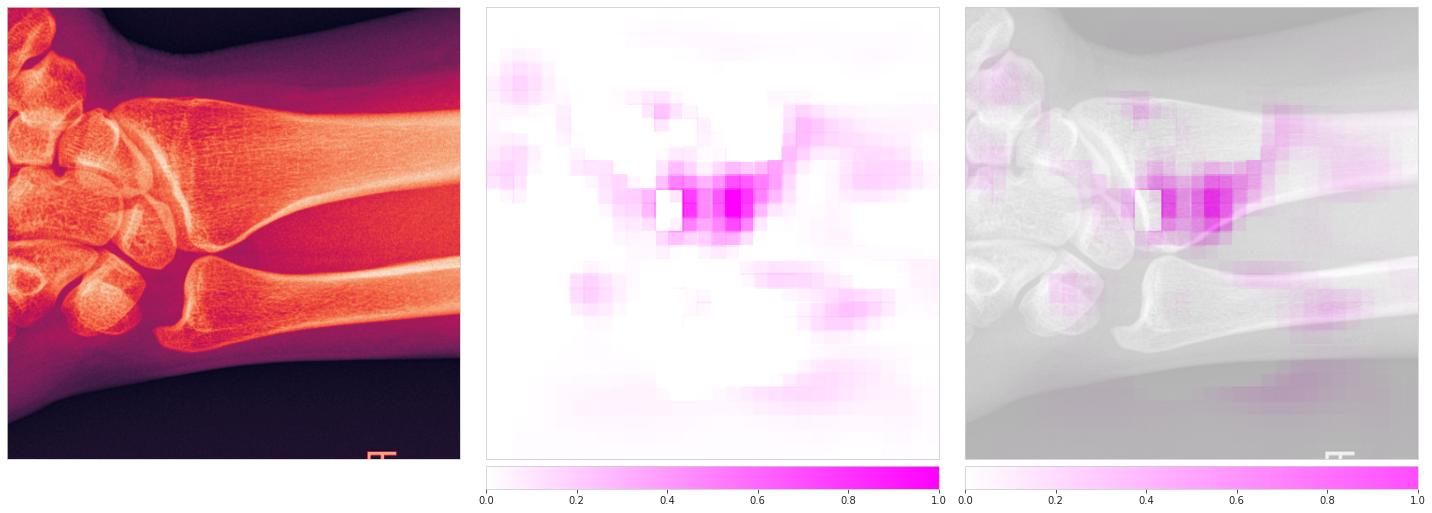

In [18]:
from captum.attr import Occlusion
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(input,
                                       strides = (16),
                                       target=pred_label_idx,
                                       sliding_window_shapes=(1,30,30),
                                       baselines=0)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.cpu().detach().numpy()),
                                      np.transpose(transformed_img.cpu().detach().numpy()),
                                      methods=["original_image", "heat_map","blended_heat_map"],
                                      signs=['all', 'positive','positive'],
                                      cmap=default_cmap,
                                      show_colorbar=True,
                                      fig_size=(20,20),
                                      alpha_overlay=0.7)

## Abspeichern der Okkulsions-Bilder


In [ ]:
occlusion1 = Occlusion(model)
def viz_image(input, transformed_img,pred_label_idx):
    attributions_occ1 = occlusion1.attribute(input,
                                             strides=(8),
                                             target=pred_label_idx,
                                             sliding_window_shapes=(1, 15, 15),
                                             baselines=0)

    _ = viz.visualize_image_attr(
                                 np.transpose(attributions_occ1.cpu().detach().numpy()),
                                 np.transpose(transformed_img1.cpu().detach().numpy()),
                                 show_colorbar=False,
                                 method="blended_heat_map",
                                 sign="positive"
                                 )
    return



In [ ]:
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
result = []
labels = ["Pneomothorax","Cardiomaly"]
for i in pd.read_csv("/home/riccardnef/PycharmProjects/new/bachelor_thesis_2022/data/Chest/BBox_List_2017_pneumo_cardio_lean.csv")["path"].tolist():
    img = Image.open(f"/home/riccardnef/PycharmProjects/new/bachelor_thesis_2022/data/Chest/{i}")

    transformed_img = transform(img)
    input = transform_normalize(transformed_img)
    input = input.unsqueeze(0)

    output = model(input)
    output = F.softmax(output, dim=1)
    prediction_score1, pred_label_idx = torch.topk(output, 1)

    pred_label_idx1.squeeze_()
    print('Predicted:', pred_label_idx, '(', prediction_score1.squeeze().item(), ')')

    transformed_img = transform(img)
    #print(f"label: {labels[df[df['path'] == i]['label'].item()]}")
    p = viz_image(input, transformed_img,pred_label_idx)

    #p.savefig(f"/home/riccardnef/PycharmProjects/new/bachelor_thesis_2022/Notebooks/XAI/data/2dheatmapsOcculusion/HEAT?{i[18:]}",bbox_inches="tight",pad_inches=0 )

## Vergleich von Okkulsion von verschiedenen Modellen

In [17]:
import os

# list files from directory
files = os.listdir("/home/riccardnef/PycharmProjects/new/bachelor_thesis_2022/Notebooks/XAI/data")
# filter list to only files with .pth extension
files = [file for file in files if file.endswith(".pth")]

for file in files :
    model = AlexNet().to("cpu")
    model.load_state_dict(torch.load(f"data/{file}",map_location=torch.device('cpu')))
    model = model.eval()
    del occlusion1
    occlusion1 = Occlusion(model)
    print("model: ", file)
    viz_image(input, transformed_img,pred_label_idx)

FileNotFoundError: [Errno 2] No such file or directory: '/home/riccardnef/PycharmProjects/new/bachelor_thesis_2022/Notebooks/XAI/data'